# On Analyzing Real World Time Series for Forecasting Stock Data - Apple Raw Data
- TUTORIAL: [simplestockpredictionautoregression.ipynb](https://gist.github.com/DanielWicz/e2f90648e46da599080fed70d11cc09c)
- I also have the code in the play folder. Have my code resemble his.
- With splitting data


## TODOs
- [x] Autoget list of lags
- [ ] Reconfigure AR model to train same model every lag (and NOT a new model per lag)
- [ ] Reconstruct my plots to be like his

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

from collections import namedtuple
from data_loader import build_stock_uts
from ts_models import Model, PersistenceWalkForward, AR, MA, ARMA, EvaluationMetric
from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Stock Data Analysis

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data
11. Split Returns Data
12. Initialize Autoregressive `AR(p)` Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
24. Follow-up

### Load Raw Data

In [2]:
# Only grab stocks whose data is available for the entire time period
start_date, end_date = "2011-01-01", "2021-01-01"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("AAPL", "Apple"),
    ("INTC", "Intel")
]
independent_variable = "Close"
# frequency = 
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=start_date, end_date=end_date, frequency='1d') for s in stocks}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

In [4]:
stock_symbol = 'AAPL'
type(stocks[stock_symbol]), stocks[stock_symbol]

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Close))

In [5]:
stock_series = stocks[stock_symbol].get_series()
stock_series

array([ 11.63000011,  11.87285709,  11.76964283, ..., 138.05000305,
       135.58000183, 134.08000183])

In [6]:
stock_df = stocks[stock_symbol].get_as_df()
stock_df

,Close
Date,
2011-01-03,11.630000
2011-01-04,11.872857
2011-01-05,11.769643
2011-01-06,11.954286
2011-01-07,11.928214
...,...
2020-12-24,131.320007
2020-12-28,133.990005
2020-12-29,138.050003


### Plot Raw Data

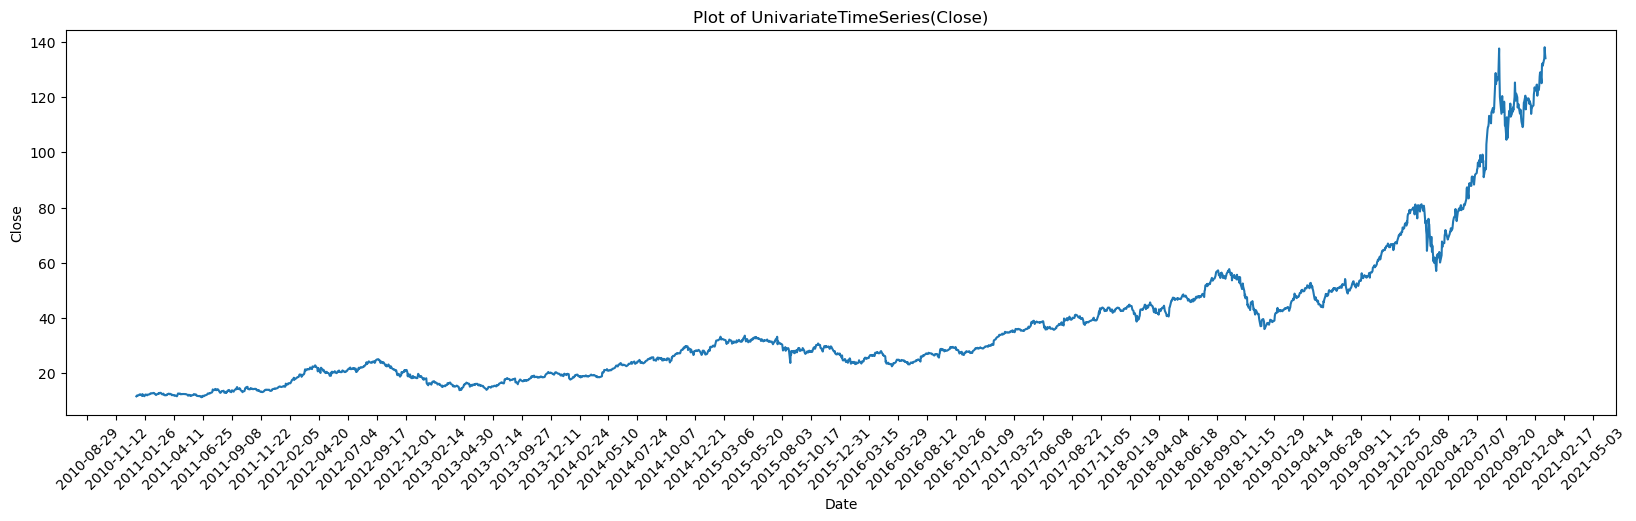

In [7]:
stocks[stock_symbol].plot(tick_skip=75)

### Get Descriptive Statistics of Raw Data

In [8]:
stocks[stock_symbol].get_statistics()

,Close
count,2517.000000
mean,36.215310
std,24.443476
min,11.310000
25%,19.695715
50%,28.264999
75%,43.869999
max,138.050003


In [9]:
stocks[stock_symbol].max_min_range()

{'Max': Close    138.050003
 dtype: float64,
 'Min': Close    11.31
 dtype: float64,
 'Range': Close    126.740003
 dtype: float64}

In [10]:
stocks[stock_symbol].autocorrelation(3)

0.9869656948384335

In [11]:
threshold_acorrs = stocks[stock_symbol].autocorrelation_with_threshold()
len(threshold_acorrs)

738

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary.
    - Can we verify this non-stationary with plotting the Autocorrelation?

In [12]:
stocks[stock_symbol].stationarity_test(stock_df)

ADF Statistic: 3.469060
p-value: 1.000000 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### Plot Autocorrelation and Partial Autocorrelation of Raw Data

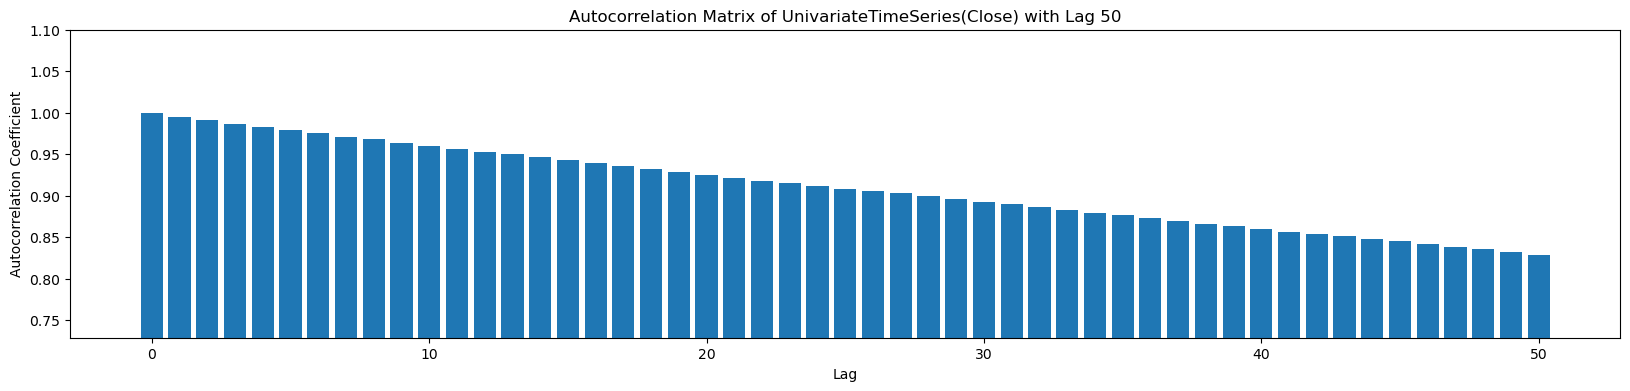

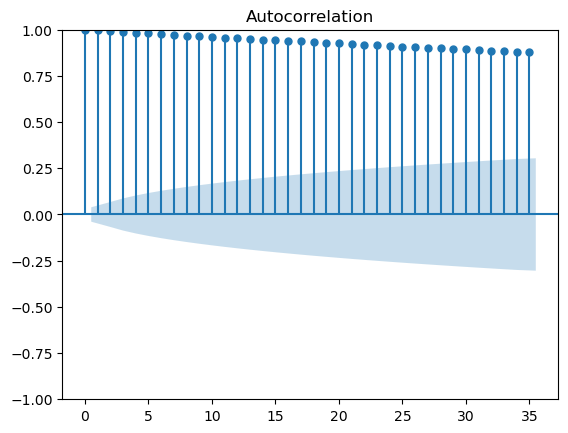

In [13]:
stocks[stock_symbol].plot_autocorrelation(50)

- Above, the data is highly correlated which means that the k-th lag observation has some impact on the most recent observation.

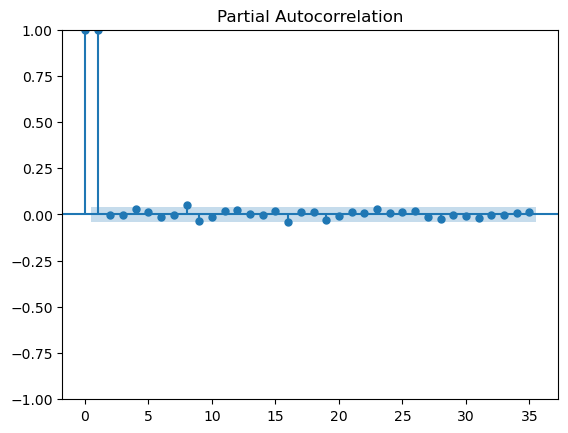

In [14]:
stocks[stock_symbol].plot_partial_autocorrelation(35)

- Above, the data shows a rapid decay at lag 2. 

- The Partial ACorr rapidly decays as lag observation 1, so if we use an MA, we'd go with AR(1).

In [15]:
len(stocks[stock_symbol].get_series()), stocks[stock_symbol].get_series()

(2517,
 array([ 11.63000011,  11.87285709,  11.76964283, ..., 138.05000305,
        135.58000183, 134.08000183]))

In [16]:
days_to_predict = 10
print(f'Test days considered {days_to_predict}\n')
print(f'Training days considered {stocks[stock_symbol].get_series().shape[0] - days_to_predict}\n')

Test days considered 10

Training days considered 2507



### Initialize Autoregressive AR(p) Model

- How to determine the proper lag value? Look at the Partial ACor plot.

In [17]:
# true_labels = stocks[stock_symbol].get_series()
# true_labels

In [18]:
# end = len(stock_df)

# subset_of_true_labels = true_labels[:end]
# len(subset_of_true_labels), subset_of_true_labels

In [19]:
train_data = stocks[stock_symbol].get_as_df()[:-days_to_predict]
len(train_data), train_data

(2507,
                  Close
 Date                  
 2011-01-03   11.630000
 2011-01-04   11.872857
 2011-01-05   11.769643
 2011-01-06   11.954286
 2011-01-07   11.928214
 ...                ...
 2020-12-10  120.500000
 2020-12-11  122.430000
 2020-12-14  122.599998
 2020-12-15  124.339996
 2020-12-16  127.410004
 
 [2507 rows x 1 columns])

In [20]:
test_data = stocks[stock_symbol].get_as_df()[-days_to_predict:]
len(test_data), test_data

(10,
                  Close
 Date                  
 2020-12-17  128.899994
 2020-12-18  128.960007
 2020-12-21  125.019997
 2020-12-22  131.610001
 2020-12-23  132.160004
 2020-12-24  131.320007
 2020-12-28  133.990005
 2020-12-29  138.050003
 2020-12-30  135.580002
 2020-12-31  134.080002)

In [21]:
# create an object from the AR() class
ar_model_class = AR()

# call the function to train our AR model
trained_ar_model = ar_model_class.train_ar_model(train_data, threshold_acorrs)

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [22]:
trained_ar_model

### Predict Forecasts of Retruns Data

In [23]:
ar_predictions = ar_model_class.predict(trained_ar_model, train_data, test_data)
ar_predictions

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


[2507    131.429911
 2508    129.468821
 2509    129.113660
 2510    125.233575
 2511    125.957307
 2512    128.594608
 2513    126.019837
 2514    129.938983
 2515    127.403531
 2516    130.187019
 dtype: float64]

In [24]:
# mse_gsts = EvaluationMetric.eval_mse(subset_of_true_labels, ar_predictions)
# mse_gsts

### Plot Actual Forecasts vs Predicted Forecasts for Returns Data

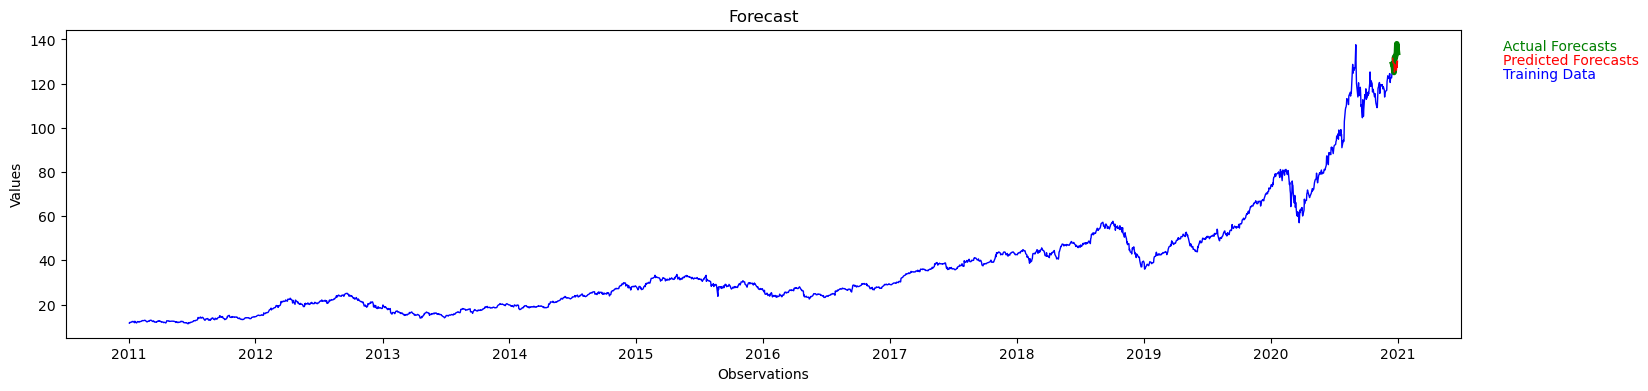

In [25]:
EvaluationMetric.plot_forecast(train_data, test_data, ar_predictions)

### Follow-up
- What can we determine from this?
    - `AR`, `MA`, `ARMA` aren't perfoming so well on the returns data. Do I need to convert back to the raw data?
    - `Persistence RW` model on the returns mse is at 0 but the plot isn't directly aligning. There are minor errors here.
- Which AR(p) lag performs the best?
    - Difficult to state. 
- Can we do better?
    - We must lol!
- What to consider?
    - [ ] Log Likelihood
    - [ ] AIC
    - [ ] BIC
    - [ ] HQIC
    - [ ] Ljung-Box (L1) (Q)
    - [ ] Jarque-Bera (JB)
    - [ ] Prob(Q):
    - [ ] Prob(JB):
    - [ ] Heteroskedasticity (H):
    - [ ] Skew
    - [ ] Prob(H) (two-sided)
    - [ ] Kurtosis